In [85]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
#import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

In [86]:
TRAIN_PATH="DRIVE/training/"
TEST_PATH="DRIVE/test/"

In [87]:
train_ids=next(os.walk(TRAIN_PATH+'images/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'images/'))[2][:]
print(len(train_ids))

20


In [88]:
input_height = IMG_HEIGHT = 224
input_width = IMG_WIDTH = 224
IMG_CHANNELS = 3

In [89]:

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'images/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'mask/' + id_[:-4] + '_mask.gif'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

Resizing training images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_13708\727015007.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.48it/s]


Resizing test images and masks


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\manda\AppData\Local\Temp\ipykernel_13708\727015007.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.49it/s]


In [90]:
print(X_train.shape, Y_test.shape)

(20, 224, 224, 3) (20, 224, 224, 1)


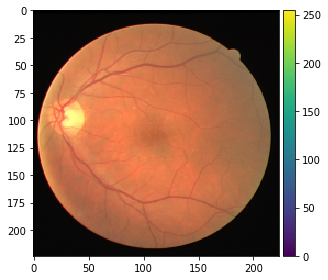

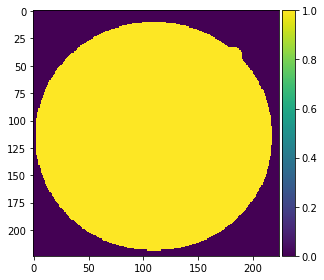

In [91]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

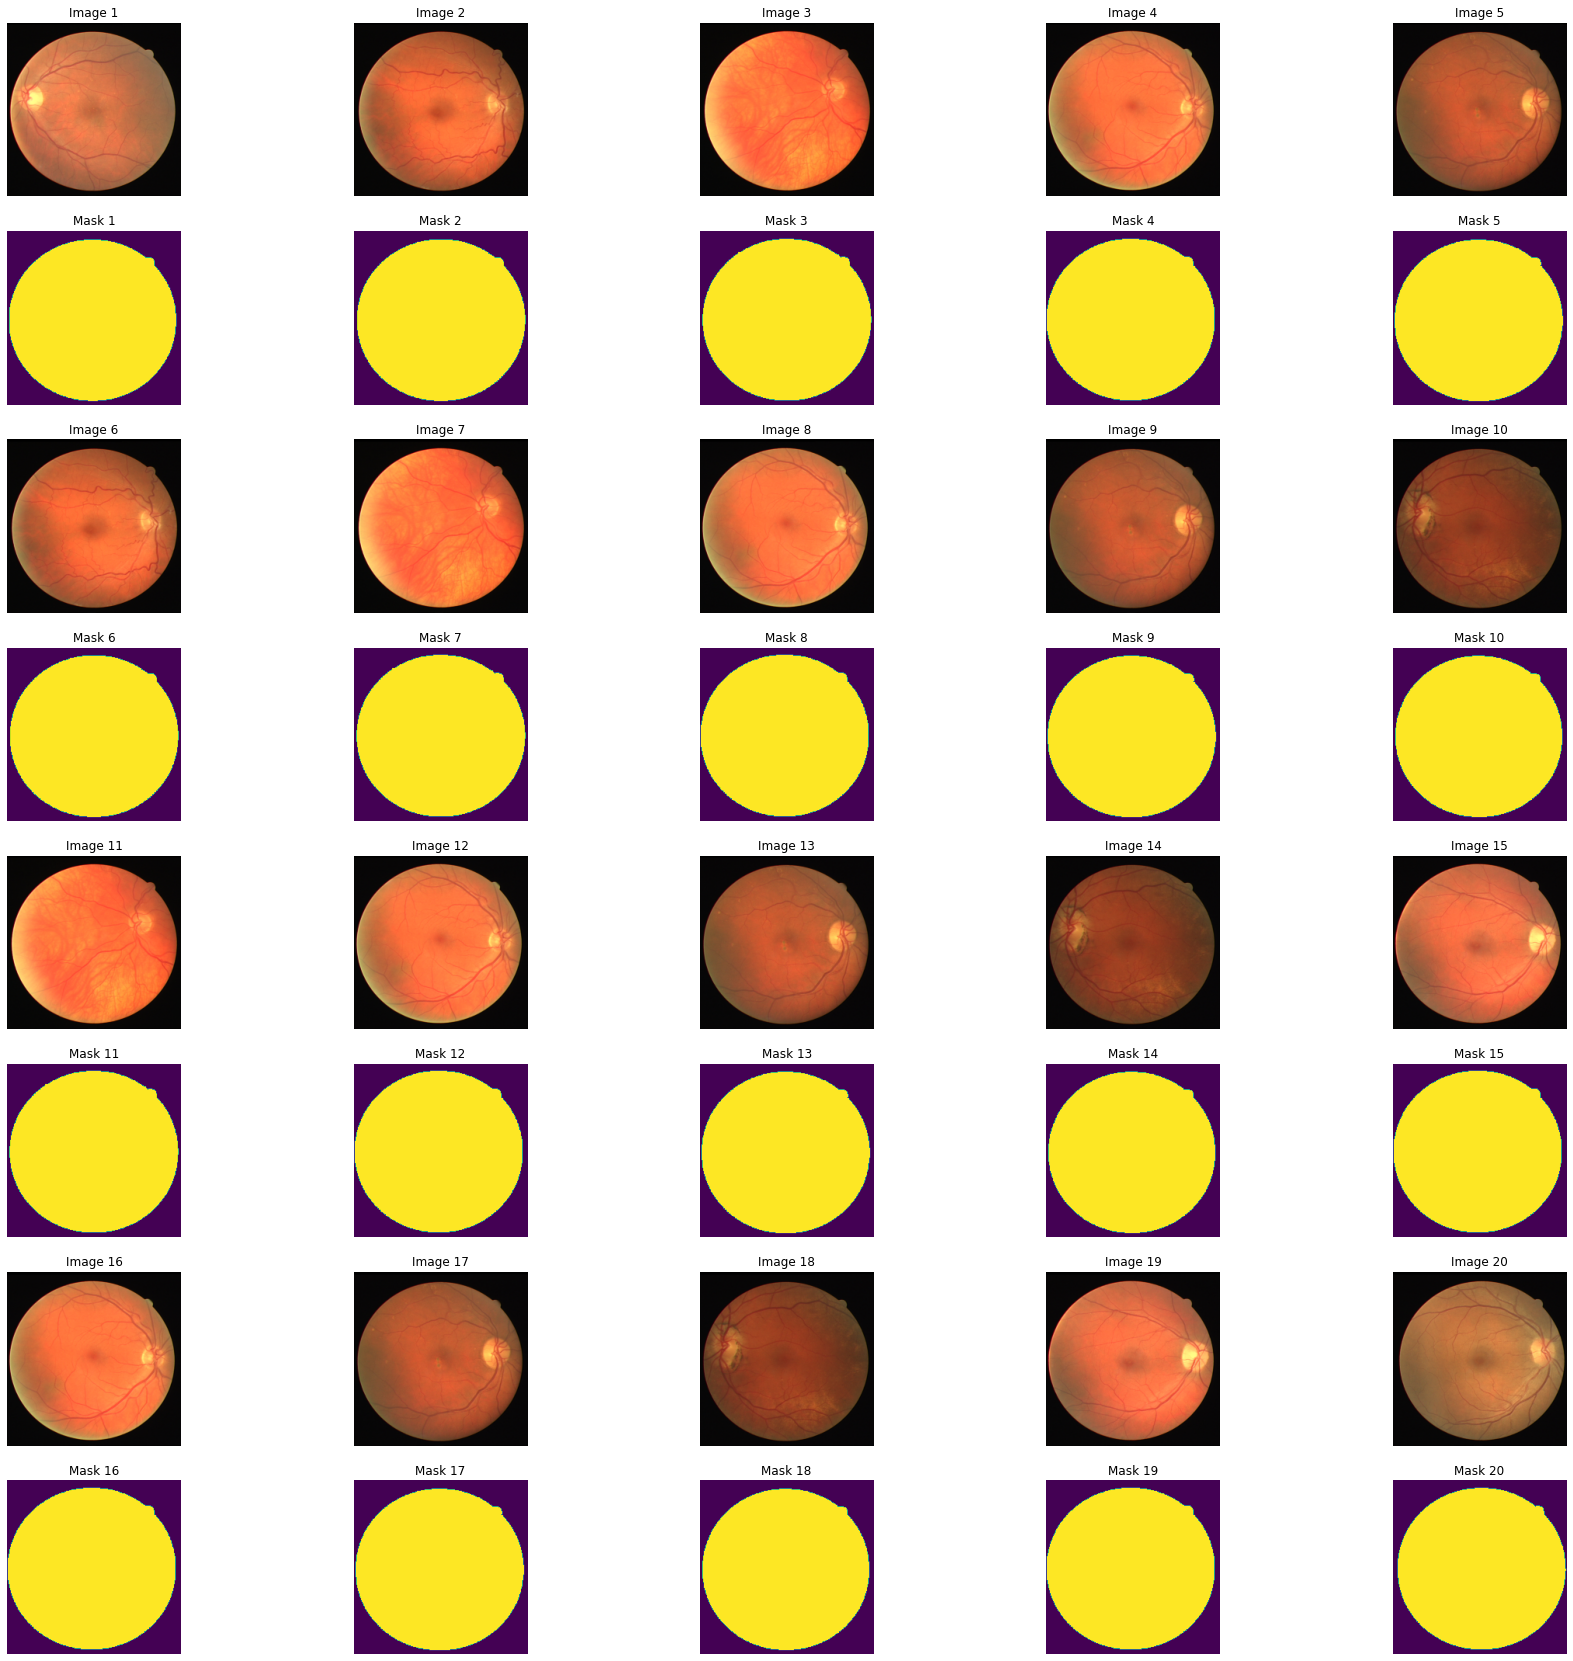

In [92]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

In [93]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D

CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}


class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), attn.dtype)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        #if self.include_top:
           # x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=1000, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(pretrained_ckpt, options=load_locally)
        else:
            net.load_weights(pretrained_ckpt)

    return net

In [94]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

In [95]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=128):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 96
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)

def rotation(image):
    augmented_image = tf.image.rot90(image)
    return augmented_image

@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(rotation, image, p=0.5)
    #image = random_apply(color_jitter, image, p=0.9)
    #image = random_apply(color_drop, image, p=0.3)
    #image = random_apply(solarize, image, p=0.3)
    return image

In [96]:
AUTO = tf.data.AUTOTUNE
CROP_TO = IMG_HEIGHT
SEED = 42
BATCH_SIZE = 4
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

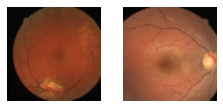

In [97]:
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    #print(sample_images_one[n].numpy().shape)
    plt.axis("off")
plt.show()

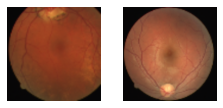

In [98]:
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(2):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [99]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss 

In [100]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [101]:
class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Implements an LR scheduler that warms up the learning rate for some training steps
    (usually at the beginning of the training) and then decays it
    with CosineDecay (see https://arxiv.org/abs/1608.03983)
    """

    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [102]:
PROJECT_DIM = IMG_HEIGHT/2
BATCH_SIZE = 8
EPOCHS = 100
WEIGHT_DECAY = 5e-4
TRAIN_FLG = 1 # 0 - No Training, 1 - Training
val_split = 0.3

STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

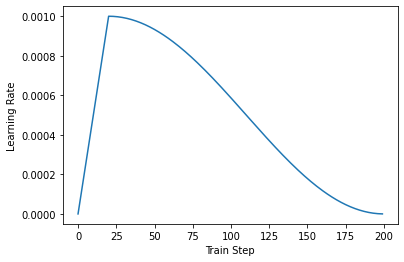

In [103]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [121]:
def projection_head(x, hidden_dim=128):
    """Constructs the projection head."""
    for i in range(2):
        x = Dense(
            hidden_dim,
            name=f"projection_layer_{i}",
            kernel_regularizer=l2(WEIGHT_DECAY),
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    outputs = Dense(hidden_dim, name="projection_output")(x)
    return outputs
'''inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
s :  KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), name='rescaling/add:0', description="created by layer 'rescaling'")
x :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 128), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
skip_1 :  [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'add')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'add_1')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'add_2')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'add_3')>]
bottleneck :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='add_4/add:0', description="created by layer 'add_4'")
trunk-output : KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='global_average_pooling2d/Mean:0', description="created by layer 'global_average_pooling2d'")
projection-outputs : KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='projection_output/BiasAdd:0', description="created by layer 'projection_output'")
Model : <keras.engine.functional.Functional object at 0x0000020AFBBD97F0>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 16  91         ['rescaling[0][0]']              
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['separable_conv2d[0][0]']       
 alization)                     )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['batch_normalization[0][0]']    
                                )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 256, 256, 16  416        ['activation[0][0]']             
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['separable_conv2d_1[0][0]']     
 rmalization)                   )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  64          ['rescaling[0][0]']              
                                )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 256, 256, 16  0           ['batch_normalization_1[0][0]']  
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 rmalization)                   )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['activation_1[0][0]']           
                                )                                                                 
                                                                                                  
 add (Add)                      (None, 256, 256, 16  0           ['batch_normalization_2[0][0]',  
                                )                                 'dropout[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['add[0][0]']                    
                                )                                                                 
                                                                                                  
 separable_conv2d_2 (SeparableC  (None, 128, 128, 32  688        ['max_pooling2d[0][0]']          
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 128, 32  128        ['separable_conv2d_2[0][0]']     
 rmalization)                   )                                                                 
                                                                                                  
 activation_2 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_3[0][0]']  
                                )                                                                 
                                                                                                  
 separable_conv2d_3 (SeparableC  (None, 128, 128, 32  1344       ['activation_2[0][0]']           
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 128, 128, 32  128        ['separable_conv2d_3[0][0]']     
 rmalization)                   )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  544         ['max_pooling2d[0][0]']          
                                )                                                                 
                                                                                                  
 activation_3 (Activation)      (None, 128, 128, 32  0           ['batch_normalization_4[0][0]']  
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 128, 128, 32  128        ['conv2d_1[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 dropout_1 (Dropout)            (None, 128, 128, 32  0           ['activation_3[0][0]']           
                                )                                                                 
                                                                                                  
 add_1 (Add)                    (None, 128, 128, 32  0           ['batch_normalization_5[0][0]',  
                                )                                 'dropout_1[0][0]']              
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)  0           ['add_1[0][0]']                  
                                                                                                  
 separable_conv2d_4 (SeparableC  (None, 64, 64, 64)  2400        ['max_pooling2d_1[0][0]']        
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 64)  256         ['separable_conv2d_4[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 64, 64, 64)  4736        ['activation_4[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 64)  256         ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 64)   2112        ['max_pooling2d_1[0][0]']        
                                                                                                  
 activation_5 (Activation)      (None, 64, 64, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 64, 64, 64)   0           ['activation_5[0][0]']           
                                                                                                  
 add_2 (Add)                    (None, 64, 64, 64)   0           ['batch_normalization_8[0][0]',  
                                                                  'dropout_2[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 64)  0           ['add_2[0][0]']                  
                                                                                                  
 separable_conv2d_6 (SeparableC  (None, 32, 32, 128)  8896       ['max_pooling2d_2[0][0]']        
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['separable_conv2d_6[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 separable_conv2d_7 (SeparableC  (None, 32, 32, 128)  17664      ['activation_6[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['separable_conv2d_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 128)  8320        ['max_pooling2d_2[0][0]']        
                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 128)  512        ['conv2d_3[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_3 (Dropout)            (None, 32, 32, 128)  0           ['activation_7[0][0]']           
                                                                                                  
 add_3 (Add)                    (None, 32, 32, 128)  0           ['batch_normalization_11[0][0]', 
                                                                  'dropout_3[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 128)  0          ['add_3[0][0]']                  
                                                                                                  
 separable_conv2d_8 (SeparableC  (None, 16, 16, 256)  34176      ['max_pooling2d_3[0][0]']        
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_12 (BatchN  (None, 16, 16, 256)  1024       ['separable_conv2d_8[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 256)  0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 16, 16, 256)  68096      ['activation_8[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_13 (BatchN  (None, 16, 16, 256)  1024       ['separable_conv2d_9[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 256)  33024       ['max_pooling2d_3[0][0]']        
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 256)  0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_4 (Dropout)            (None, 16, 16, 256)  0           ['activation_9[0][0]']           
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 256)  0           ['batch_normalization_14[0][0]', 
                                                                  'dropout_4[0][0]']              
                                                                                                  
 global_average_pooling2d (Glob  (None, 256)         0           ['add_4[0][0]']                  
 alAveragePooling2D)                                                                              
                                                                                                  
 projection_layer_0 (Dense)     (None, 128)          32896       ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128)         512         ['projection_layer_0[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_10 (Activation)     (None, 128)          0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 projection_layer_1 (Dense)     (None, 128)          16512       ['activation_10[0][0]']          
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128)         512         ['projection_layer_1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 128)          0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 projection_output (Dense)      (None, 128)          16512       ['activation_11[0][0]']          
                                                                                                  
==================================================================================================
Total params: 255,467
Trainable params: 251,979
Non-trainable params: 3,488'''


def build_encoder(shape, hidden_dim=128):
    inputs = Input(shape)
    print("inputs : ", inputs)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    print("s : ", s)
    #s = inputs
    
    
   # st_1=SwinTransformerBlock(dim=128,num_heads=3,input_resolution=(None,224,224,3))()
    #print("st_1",st_1)
    #PM_1=PatchMerging(st_1,dim=128)(st_1);
    #st_2=SwinTransformerBlock(PM_1, input_resolution=(224, 224),num_heads=64)(PM_1);
    #PM_2=PatchMerging(st_2,dim=128)(st_2);
    #st_3=SwinTransformerBlock(PM_2,input_resolution=(224,224),num_heads=12)(PM_2);
    
    #print(st_3)
    
    x=SwinTransformerModel()(inputs)
    
    #trunk_output = GlobalAvgPool2D()(x)
    #projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)
    
    model = Model(inputs, x)
    
   
    return model


def build_decoder(shape, hidden_dim=128):
    inputs = Input(shape)
    print("inputs : ", inputs)
    s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    print("s : ", s)
    #s = inputs
    
    
   # st_1=SwinTransformerBlock(dim=128,num_heads=3,input_resolution=(None,224,224,3))()
    #print("st_1",st_1)
    #PM_1=PatchMerging(st_1,dim=128)(st_1);
    #st_2=SwinTransformerBlock(PM_1, input_resolution=(224, 224),num_heads=64)(PM_1);
    #PM_2=PatchMerging(st_2,dim=128)(st_2);
    #st_3=SwinTransformerBlock(PM_2,input_resolution=(224,224),num_heads=12)(PM_2);
    
    #print(st_3)
    
    x=SwinTransformerModel()(inputs)
    
    #trunk_output = GlobalAvgPool2D()(x)
    #projection_outputs = projection_head(trunk_output, hidden_dim=hidden_dim)
    
    
    
   
    return x

In [105]:
#unet_enc, skip_connetions = build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=128)
unet_enc=build_encoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=128)
unet_enc.summary()

inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
s :  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), name='rescaling_4/add:0', description="created by layer 'rescaling_4'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 swin_tiny_patch4_window7_22  (None, 768)              27769058  
 4 (SwinTransformerModel)                                        
                                                                 
Total params: 27,769,058
Trainable params: 27,519,354
Non-trainable params: 249,704
_________________________________________________________________


Training
Epoch 1/100
5/5 [==============================] - 124s 5s/step - loss: 1832.4567
Epoch 2/100
5/5 [==============================] - 25s 5s/step - loss: 1880.0150
Epoch 3/100
5/5 [==============================] - 23s 5s/step - loss: 2057.0391
Epoch 4/100
5/5 [==============================] - 23s 5s/step - loss: 1858.6888
Epoch 5/100
5/5 [==============================] - 23s 5s/step - loss: 1869.8538
Epoch 6/100
5/5 [==============================] - 23s 5s/step - loss: 1885.8020
Epoch 7/100
5/5 [==============================] - 23s 5s/step - loss: 1230.6699
Epoch 8/100
5/5 [==============================] - 23s 5s/step - loss: 2016.4948
Epoch 9/100
5/5 [==============================] - 24s 5s/step - loss: 1628.5710
Epoch 10/100
5/5 [==============================] - 23s 5s/step - loss: 1120.7949
Epoch 11/100
5/5 [==============================] - 23s 5s/step - loss: 1755.8582
Epoch 12/100
5/5 [==============================] - 23s 5s/step - loss: 2587.2070
Epoch 13/100
5/

5/5 [==============================] - 25s 5s/step - loss: 2734.9985


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


INFO:tensorflow:Assets written to: barlow_twins_unet\assets


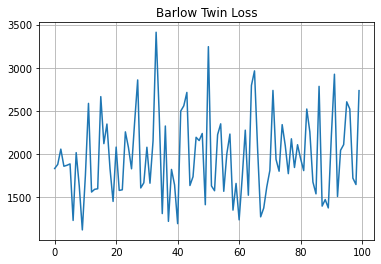

In [106]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
barlow_twins = BarlowTwins(unet_enc)
barlow_twins.compile(optimizer=optimizer)
if TRAIN_FLG:
    print("Training")
    barlow_twins.encoder.get_weights()[0]
    history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)
    barlow_twins.encoder.save('barlow_twins_unet')
    plt.plot(history.history["loss"])
    plt.grid()
    plt.title("Barlow Twin Loss")
    plt.show()
elif not TRAIN_FLG:
    print("Loading training weights")
    barlow_twins.encoder.load_weights('barlow_twins_unet')

In [114]:
#backbone = tf.keras.Model(
    #barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output
)
#backbone.layers

In [115]:
#backbone.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [116]:
#new_skip_connections = [backbone.get_layer(index=11).output, 
                        #backbone.get_layer(index=22).output, 
                        #backbone.get_layer(index=33).output, 
                        #backbone.get_layer(index=44).output]

ValueError: Was asked to retrieve layer at index 11 but model only has 1 layers.

In [ ]:
#new_skip_connections

In [119]:
#backbone.output


AttributeError: 'TensorShape' object has no attribute 'Flatten'

In [123]:
backbone.trainable=True
#x = backbone.output
#x = bottleneck(x)

x = build_decoder((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), hidden_dim=128)

print("x",x)
outputs = output(x)
model = Model(barlow_twins.encoder.input, outputs)

inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'")
s :  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), name='rescaling_7/add:0', description="created by layer 'rescaling_7'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='swin_tiny_patch4_window7_224/global_average_pooling1d_4/Mean:0', description="created by layer 'swin_tiny_patch4_window7_224'")


ValueError: Input 0 of layer "conv2d_2" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 768)

In [ ]:
model.summary()

In [ ]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

In [ ]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

In [ ]:
log_path = "logs/"
keyname = "BT-Unet"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [ ]:
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

In [ ]:
preds_train = model.predict(X_train_20[:int(X_train_20.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train_20[int(X_train_20.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train_20[:int(X_train_20.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train_20[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [ ]:
evalResult(gt_train, preds_train_t)

In [ ]:
evalResult(gt_x, preds_x_t)

In [ ]:
evalResult(gt_test, preds_test_t)

In [ ]:
x=0

xx = [1,0,0]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

In [ ]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3
